# Yahoo Finance - Model Comparison

Testing ARIMA, Exponential Smoothing, and XGBoost on stock data.


In [25]:
import sys
sys.path.insert(0, "../../src")

import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from darts import TimeSeries
from darts.metrics import mape, rmse, mae

from gw2ml.modeling import ARIMAModel, ExponentialSmoothingModel, XGBoostModel

plt.style.use("seaborn-v0_8-whitegrid")
plt.rcParams["figure.figsize"] = (14, 6)


## 1. Load Stock Data


In [26]:
# Configuration
TICKER = "AAPL"  # Try: AAPL, MSFT, GOOGL, NVDA, TSLA
PERIOD = "2y"
YF_INTERVAL = "1d"  # Yahoo interval

# Darts frequency (important!): use Business Days to avoid weekend NaNs
DARTS_FREQ = "B"

FORECAST_DAYS = 30
TEST_DAYS = 60

print(f"Loading {TICKER} data...")
stock = yf.Ticker(TICKER)
df = stock.history(period=PERIOD, interval=YF_INTERVAL)

print(f"\n{TICKER} - {stock.info.get('longName', 'N/A')}")
print(f"Data: {df.index[0].date()} to {df.index[-1].date()}")
print(f"Points: {len(df)}")
df.tail()


Loading AAPL data...

AAPL - Apple Inc.
Data: 2023-12-27 to 2025-12-26
Points: 502


,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-12-19 00:00:00-05:00,272.149994,274.600006,269.899994,273.670013,144632000,0.0,0.0
2025-12-22 00:00:00-05:00,272.859985,273.880005,270.510010,270.970001,36571800,0.0,0.0
2025-12-23 00:00:00-05:00,270.839996,272.500000,269.559998,272.359985,29642000,0.0,0.0
2025-12-24 00:00:00-05:00,272.339996,275.429993,272.200012,273.809998,17910600,0.0,0.0
2025-12-26 00:00:00-05:00,274.160004,275.369995,272.859985,273.399994,21455300,0.0,0.0


Cleaned: 502 -> 502 points (removed 0 NaN)
Regularized (B): 502 -> 523 points (filled missing business days)
Series: 523 points
Train: 463 points
Test: 60 points


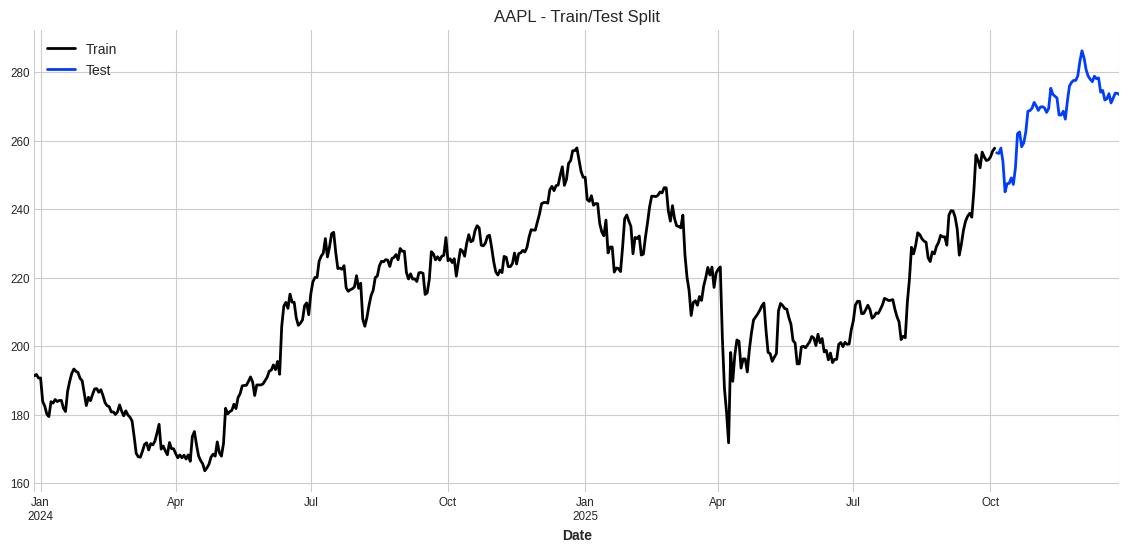

In [ ]:
# Clean data: remove NaN, remove timezone
df_clean = df[["Close"]].dropna().copy()
df_clean.index = df_clean.index.tz_localize(None)

print(f"Cleaned: {len(df)} -> {len(df_clean)} points (removed {len(df) - len(df_clean)} NaN)")

# Ensure a regular time axis without NaNs.
# With stocks, calendar days include weekends; forcing daily freq would insert weekends -> NaNs.
# We use business-day frequency and forward-fill missing values (e.g. holidays).
df_regular = df_clean.asfreq(DARTS_FREQ)
df_regular["Close"] = df_regular["Close"].ffill()
df_regular = df_regular.dropna()

nan_count = int(df_regular.isna().sum().sum())
if nan_count > 0:
    raise ValueError(f"Data still contains NaNs after regularization: {nan_count}")

print(f"Regularized ({DARTS_FREQ}): {len(df_clean)} -> {len(df_regular)} points (filled missing business days)")

# ─────────────────────────────────────────────────────────────
# Build targets + covariates for better ML performance
# - Target for XGBoost: log-returns (more stationary)
# - Past covariates: rolling stats on returns
# - Future covariates: weekday one-hot (Mon..Fri)
# ─────────────────────────────────────────────────────────────
df_model = df_regular.copy()
df_model["log_close"] = np.log(df_model["Close"].astype(float))
df_model["log_return"] = df_model["log_close"].diff()

# Rolling features (past covariates)
df_model["ret_mean_5"] = df_model["log_return"].rolling(5).mean()
df_model["ret_std_5"] = df_model["log_return"].rolling(5).std()
df_model["ret_sum_5"] = df_model["log_return"].rolling(5).sum()

df_model["ret_mean_20"] = df_model["log_return"].rolling(20).mean()
df_model["ret_std_20"] = df_model["log_return"].rolling(20).std()
df_model["ret_sum_20"] = df_model["log_return"].rolling(20).sum()

# Future covariates (weekday)
weekday = df_model.index.weekday  # 0=Mon ... 6=Sun
for i, name in enumerate(["mon", "tue", "wed", "thu", "fri"]):
    df_model[f"dow_{name}"] = (weekday == i).astype(int)

# Drop NaNs introduced by diff/rolling
feature_cols = [
    "log_return",
    "ret_mean_5", "ret_std_5", "ret_sum_5",
    "ret_mean_20", "ret_std_20", "ret_sum_20",
    "dow_mon", "dow_tue", "dow_wed", "dow_thu", "dow_fri",
]
df_model = df_model.dropna(subset=feature_cols)

# Convert to Darts TimeSeries
series = TimeSeries.from_dataframe(df_model, value_cols="Close", freq=DARTS_FREQ)
series_returns = TimeSeries.from_dataframe(df_model, value_cols="log_return", freq=DARTS_FREQ)

past_covariates = TimeSeries.from_dataframe(
    df_model,
    value_cols=["ret_mean_5", "ret_std_5", "ret_sum_5", "ret_mean_20", "ret_std_20", "ret_sum_20"],
    freq=DARTS_FREQ,
)
future_covariates = TimeSeries.from_dataframe(
    df_model,
    value_cols=["dow_mon", "dow_tue", "dow_wed", "dow_thu", "dow_fri"],
    freq=DARTS_FREQ,
)

# Split train/test (prices + returns/covariates aligned)
split_point = len(series) - TEST_DAYS
train = series[:split_point]
test = series[split_point:]

train_returns = series_returns[:split_point]

past_covariates_train = past_covariates[:split_point]
future_covariates_train = future_covariates[:split_point]

print(f"Series (price): {len(series)} points")
print(f"Series (returns): {len(series_returns)} points")
print(f"Train: {len(train)} points")
print(f"Test: {len(test)} points")

# Plot
fig, ax = plt.subplots()
train.plot(ax=ax, label="Train")
test.plot(ax=ax, label="Test")
ax.set_title(f"{TICKER} - Train/Test Split")
ax.legend()
plt.show()


## 2. ARIMA


In [28]:
arima_configs = [(1, 1, 1), (2, 1, 2), (5, 1, 0), (0, 1, 5)]
arima_results = []

for p, d, q in arima_configs:
    try:
        model = ARIMAModel(p=p, d=d, q=q).fit(train)
        forecast = model.predict(n=FORECAST_DAYS)
        
        test_overlap = test[:FORECAST_DAYS]
        m = mape(test_overlap, forecast)
        r = rmse(test_overlap, forecast)
        
        arima_results.append({"config": f"ARIMA({p},{d},{q})", "MAPE": m, "RMSE": r, "forecast": forecast})
        print(f"ARIMA({p},{d},{q}): MAPE={m:.2f}%, RMSE={r:.2f}")
    except Exception as e:
        print(f"ARIMA({p},{d},{q}): Failed - {e}")

if arima_results:
    best_arima = min(arima_results, key=lambda x: x["MAPE"])
    print(f"\n✅ Best: {best_arima['config']} (MAPE: {best_arima['MAPE']:.2f}%)")
else:
    best_arima = {"config": "ARIMA(none)", "MAPE": float("inf"), "RMSE": float("inf"), "forecast": None}


ARIMA(1,1,1): MAPE=3.41%, RMSE=10.22
ARIMA(2,1,2): MAPE=3.40%, RMSE=10.18
ARIMA(5,1,0): MAPE=3.48%, RMSE=10.44
ARIMA(0,1,5): MAPE=3.53%, RMSE=10.58

✅ Best: ARIMA(2,1,2) (MAPE: 3.40%)


## 3. Exponential Smoothing


In [ ]:
es_configs = [
    {"name": "Simple", "trend": None, "damped": False, "seasonal": None, "seasonal_periods": None},
    {"name": "Holt", "trend": "add", "damped": False, "seasonal": None, "seasonal_periods": None},
    {"name": "Damped Holt", "trend": "add", "damped": True, "seasonal": None, "seasonal_periods": None},
    # Business-day data -> weekly seasonality = 5
    {"name": "Holt-Winters (weekly)", "trend": "add", "damped": True, "seasonal": "add", "seasonal_periods": 5},
]
es_results = []

for cfg in es_configs:
    try:
        model = ExponentialSmoothingModel(
            trend=cfg["trend"],
            damped=cfg["damped"],
            seasonal=cfg["seasonal"],
            seasonal_periods=cfg["seasonal_periods"],
        ).fit(train)
        forecast = model.predict(n=FORECAST_DAYS)

        test_overlap = test[:FORECAST_DAYS]
        m = mape(test_overlap, forecast)
        r = rmse(test_overlap, forecast)

        es_results.append({"config": cfg["name"], "MAPE": m, "RMSE": r, "forecast": forecast})
        print(f"{cfg['name']}: MAPE={m:.2f}%, RMSE={r:.2f}")
    except Exception as e:
        print(f"{cfg['name']}: Failed - {e}")

if es_results:
    # Filter out NaN results
    valid_es = [r for r in es_results if not np.isnan(r["MAPE"])]
    if valid_es:
        best_es = min(valid_es, key=lambda x: x["MAPE"])
        print(f"\n✅ Best: {best_es['config']} (MAPE: {best_es['MAPE']:.2f}%)")
    else:
        best_es = es_results[0]
        print(f"\n⚠️ All ES models produced NaN")
else:
    best_es = {"config": "ES(none)", "MAPE": float("inf"), "RMSE": float("inf"), "forecast": None}


Simple: MAPE=3.43%, RMSE=10.29
Holt: MAPE=2.85%, RMSE=8.47
Damped Holt: MAPE=3.43%, RMSE=10.29

✅ Best: Holt (MAPE: 2.85%)


## 4. XGBoost


In [ ]:
def returns_forecast_to_price(forecast_returns: TimeSeries, last_train_price: float) -> TimeSeries:
    """Convert forecasted log-returns back to a price TimeSeries."""
    r = forecast_returns.values().flatten()
    last_log_price = float(np.log(last_train_price))
    forecast_log_prices = last_log_price + np.cumsum(r)
    forecast_prices = np.exp(forecast_log_prices).reshape(-1, 1)
    return TimeSeries.from_times_and_values(forecast_returns.time_index, forecast_prices)

# XGBoost on log-returns + covariates (direct multi-step forecast)
xgb_configs = [
    {
        "name": "XGB(returns+covs)",
        "lags": [1, 2, 3, 5, 10, 20, 60, 120],
        "output_chunk_length": FORECAST_DAYS,
        "n_estimators": 600,
        "max_depth": 5,
        "learning_rate": 0.05,
        "subsample": 0.8,
        "colsample_bytree": 0.8,
        "reg_lambda": 1.0,
    },
    {
        "name": "XGB(returns+covs, shallow)",
        "lags": [1, 2, 3, 5, 10, 20, 60, 120],
        "output_chunk_length": FORECAST_DAYS,
        "n_estimators": 800,
        "max_depth": 3,
        "learning_rate": 0.03,
        "subsample": 0.9,
        "colsample_bytree": 0.9,
        "reg_lambda": 1.0,
    },
]

xgb_results = []

for cfg in xgb_configs:
    try:
        model_params = {k: v for k, v in cfg.items() if k != "name"}
        model = XGBoostModel(
            **model_params,
            lags_past_covariates=[-1, -2, -3, -5, -10, -20],
            lags_future_covariates=[0, 1, 2, 3, 4],
        )

        model.fit(
            train_returns,
            past_covariates=past_covariates_train,
            future_covariates=future_covariates_train,
        )

        forecast_returns = model.predict(
            n=FORECAST_DAYS,
            past_covariates=past_covariates,
            future_covariates=future_covariates,
        )

        last_train_price = float(train.values().flatten()[-1])
        forecast_price = returns_forecast_to_price(forecast_returns, last_train_price)

        test_overlap = test[:FORECAST_DAYS]
        m = mape(test_overlap, forecast_price)
        r = rmse(test_overlap, forecast_price)

        xgb_results.append({"config": cfg["name"], "MAPE": m, "RMSE": r, "forecast": forecast_price})
        print(f"{cfg['name']}: MAPE={m:.2f}%, RMSE={r:.2f}")

    except Exception as e:
        print(f"{cfg.get('name', 'XGB')}: Failed - {str(e)[:120]}")

if xgb_results:
    best_xgb = min(xgb_results, key=lambda x: x["MAPE"])
    print(f"\n✅ Best: {best_xgb['config']} (MAPE: {best_xgb['MAPE']:.2f}%)")
else:
    print("\n❌ All XGBoost models failed!")
    best_xgb = {"config": "XGB(none)", "MAPE": float("inf"), "RMSE": float("inf"), "forecast": None}


XGB(lags=7): MAPE=3.60%, RMSE=11.57
XGB(lags=14): MAPE=11.92%, RMSE=37.28
XGB(lags=30): MAPE=11.74%, RMSE=37.54
XGB(lags=60): MAPE=8.71%, RMSE=30.86

✅ Best: XGB(lags=7) (MAPE: 3.60%)


## 5. Comparison


In [31]:
# Summary table (filter out failed models)
all_results = []
for name, result in [("ARIMA", best_arima), ("ES", best_es), ("XGB", best_xgb)]:
    if result["forecast"] is not None and not np.isinf(result["MAPE"]) and not np.isnan(result["MAPE"]):
        all_results.append({"Model": result["config"], "MAPE": result["MAPE"], "RMSE": result["RMSE"]})

if all_results:
    summary_df = pd.DataFrame(all_results).sort_values("MAPE")
    print(f"\n{'='*60}")
    print(f"📊 MODEL COMPARISON - {TICKER}")
    print(f"{'='*60}")
    print(summary_df.to_string(index=False))
    
    winner = summary_df.iloc[0]
    print(f"\n🏆 Winner: {winner['Model']} (MAPE: {winner['MAPE']:.2f}%)")
else:
    print("❌ No valid model results to compare!")



📊 MODEL COMPARISON - AAPL
       Model     MAPE      RMSE
        Holt 2.850498  8.465514
ARIMA(2,1,2) 3.401324 10.179604
 XGB(lags=7) 3.598771 11.573420

🏆 Winner: Holt (MAPE: 2.85%)


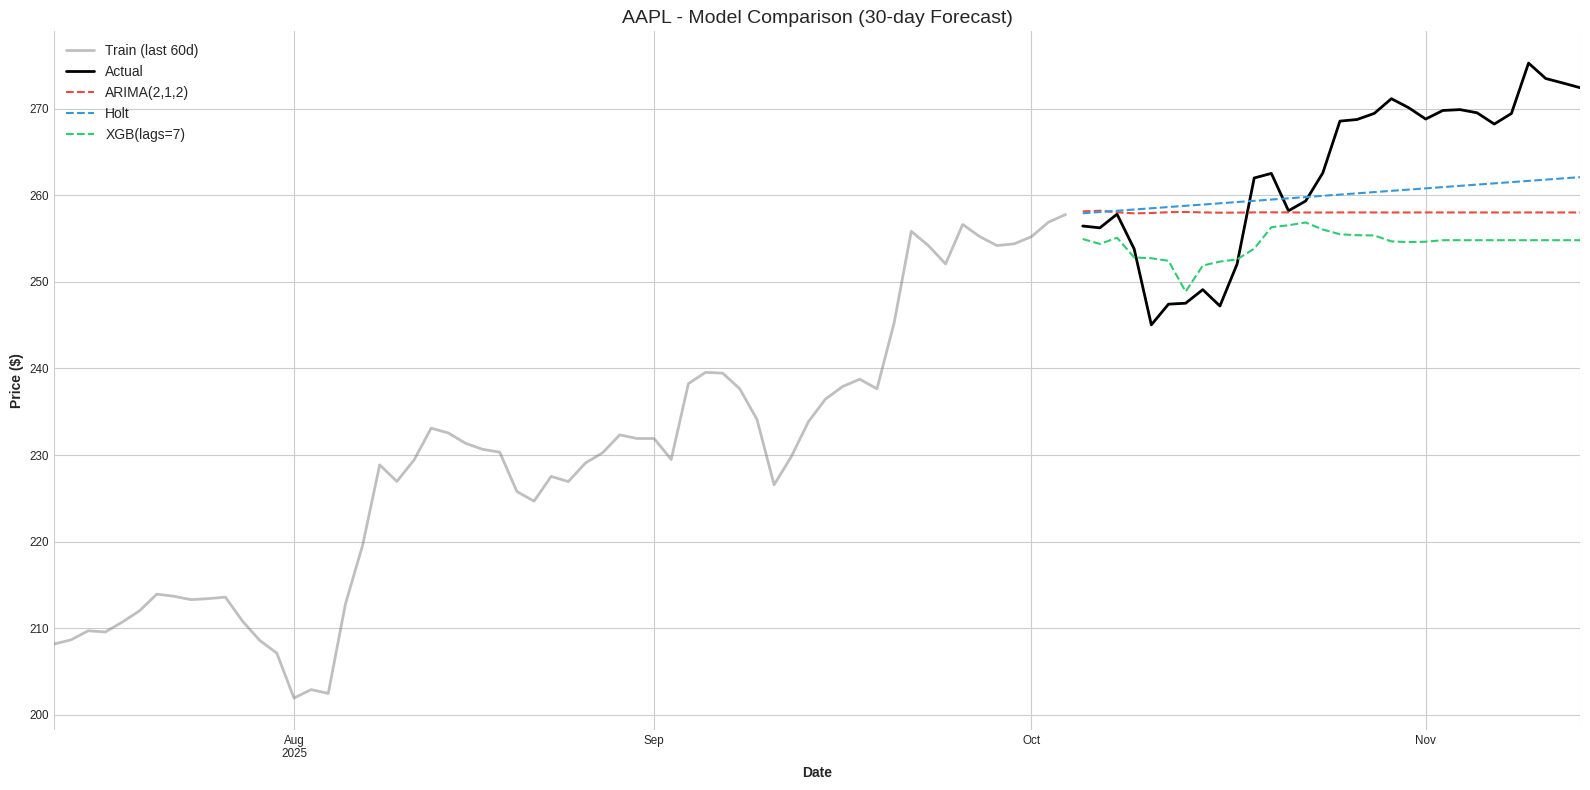

In [32]:
# Plot forecasts (only models that worked)
fig, ax = plt.subplots(figsize=(16, 8))

train[-60:].plot(ax=ax, label="Train (last 60d)", color="gray", alpha=0.5)
test[:FORECAST_DAYS].plot(ax=ax, label="Actual", color="black", linewidth=2)

colors = ["#e74c3c", "#3498db", "#2ecc71"]
forecasts = [
    (best_arima["config"], best_arima["forecast"]),
    (best_es["config"], best_es["forecast"]),
    (best_xgb["config"], best_xgb["forecast"]),
]

for (name, forecast), color in zip(forecasts, colors):
    if forecast is not None:
        forecast.plot(ax=ax, label=name, color=color, linestyle="--", linewidth=1.5)

ax.set_title(f"{TICKER} - Model Comparison ({FORECAST_DAYS}-day Forecast)", fontsize=14)
ax.legend(loc="best")
ax.set_xlabel("Date")
ax.set_ylabel("Price ($)")
plt.tight_layout()
plt.show()


## 6. Multi-Stock Comparison


In [33]:
TICKERS = ["AAPL", "MSFT", "GOOGL", "NVDA"]
multi_results = []

for ticker in TICKERS:
    print(f"\n{'='*40}")
    print(f"Testing {ticker}...")
    
    try:
        # Load and clean data
        stock = yf.Ticker(ticker)
        df = stock.history(period="2y", interval=YF_INTERVAL)
        df_clean = df[["Close"]].dropna().copy()
        df_clean.index = df_clean.index.tz_localize(None)

        # Regularize to business-day frequency to avoid weekend NaNs
        df_regular = df_clean.asfreq(DARTS_FREQ)
        df_regular["Close"] = df_regular["Close"].ffill()
        df_regular = df_regular.dropna()

        nan_count = int(df_regular.isna().sum().sum())
        if nan_count > 0:
            raise ValueError(f"{ticker}: Data contains NaNs after regularization: {nan_count}")

        series = TimeSeries.from_dataframe(df_regular, value_cols="Close", freq=DARTS_FREQ)

        train = series[:-TEST_DAYS]
        test = series[-TEST_DAYS:]
        test_overlap = test[:FORECAST_DAYS]
        
        # ARIMA
        arima = ARIMAModel(p=2, d=1, q=2).fit(train)
        arima_fc = arima.predict(n=FORECAST_DAYS)
        arima_mape = mape(test_overlap, arima_fc)
        
        # ES
        es = ExponentialSmoothingModel(trend="add", damped=True).fit(train)
        es_fc = es.predict(n=FORECAST_DAYS)
        es_mape = mape(test_overlap, es_fc)
        
        # XGBoost
        xgb = XGBoostModel(lags=30, n_estimators=200).fit(train)
        xgb_fc = xgb.predict(n=FORECAST_DAYS)
        xgb_mape = mape(test_overlap, xgb_fc)
        
        best = "ARIMA" if arima_mape <= min(es_mape, xgb_mape) else ("ES" if es_mape <= xgb_mape else "XGB")
        multi_results.append({
            "Ticker": ticker,
            "ARIMA": f"{arima_mape:.2f}%",
            "ES": f"{es_mape:.2f}%",
            "XGB": f"{xgb_mape:.2f}%",
            "Best": best
        })
        print(f"  ARIMA: {arima_mape:.2f}% | ES: {es_mape:.2f}% | XGB: {xgb_mape:.2f}%")
        
    except Exception as e:
        print(f"  Error: {str(e)[:80]}")

print(f"\n{'='*60}")
print("📊 MULTI-STOCK RESULTS")
print(f"{'='*60}")
if multi_results:
    print(pd.DataFrame(multi_results).to_string(index=False))
else:
    print("No results available")



Testing AAPL...
  ARIMA: 3.40% | ES: 3.43% | XGB: 11.74%

Testing MSFT...
  ARIMA: 1.57% | ES: 1.57% | XGB: 1.77%

Testing GOOGL...
  ARIMA: 7.32% | ES: 6.25% | XGB: 7.32%

Testing NVDA...
  ARIMA: 3.43% | ES: 3.31% | XGB: 7.19%

📊 MULTI-STOCK RESULTS
Ticker ARIMA    ES    XGB  Best
  AAPL 3.40% 3.43% 11.74% ARIMA
  MSFT 1.57% 1.57%  1.77%    ES
 GOOGL 7.32% 6.25%  7.32%    ES
  NVDA 3.43% 3.31%  7.19%    ES


## 7. Fazit

**Beobachtungen:**
- Aktiendaten zeigen oft klare Trends → ARIMA/ES funktionieren besser
- XGBoost kann Muster lernen, braucht aber gute Lag-Features
- Stock-Daten sind weniger "random walk" als GW2-Preise

**Empfehlung:**
- Für Trend-Daten: Damped Holt oder ARIMA
- Für volatile Daten: XGBoost mit Feature Engineering
